In [35]:
import numpy as np
import pandas as pd

def simulate_perturb_nb(
    G=2000,                  # number of genes
    C=4,                     # number of cell types
    P=6,                     # number of perturbations
    cells_per_combo=50,      # cells per (cell_type, perturbation)
    seed=42,

    # effect scale params
    sg=0.5,                  # std for Ag
    sc=0.4,                  # std for Agc (for active genes)
    spg=0.3,                 # std for Apg
    use_fixed_sp=False,      # if True, Apgc active effects are +/-Sp (fixed); else N(0, sp^2)
    sp=0.5,                  # fixed magnitude for Apgc if use_fixed_sp=True
    sp_std=0.5,              # std for Apgc if use_fixed_sp=False

    # sparsity
    frac_celltype_specific=0.10,  # 10% of genes have Agc
    frac_perturb_specific=0.01,   # 1% of (g,p,c) have Apgc

    # library size per cell
    libsize_mode="lognormal",     # "lognormal" or "constant"
    lib_logmean=10.0,             # log-mean for library size
    lib_logsd=0.25,               # log-sd for library size
    lib_constant=1e4,             # constant library size if mode="constant"

    # negative binomial dispersion (r). Var = mu + mu^2 / r
    nb_r=1.5,

    # return options
    return_anndata=True           # if anndata unavailable, falls back to DataFrame
):
    rng = np.random.default_rng(seed)

    # --- indices / shapes ---
    genes = np.array([f"g{i:04d}" for i in range(G)])
    cell_types = np.array([f"c{i}" for i in range(C)])
    perts = np.array([f"p{i}" for i in range(P)])

    # total cells
    Ncells = C * P * cells_per_combo

    # --- effects ---
    # Ag: (G,)
    Ag = rng.normal(0.0, sg, size=G)

    # Agc: (G, C) with 10% active genes
    active_g_for_c = rng.random(G) < frac_celltype_specific
    Agc = np.zeros((G, C), dtype=float)
    Agc[active_g_for_c, :] = rng.normal(0.0, sc, size=(active_g_for_c.sum(), C))

    # Apg: (G, P) common across cell types for each (g, p)
    Apg = rng.normal(0.0, spg, size=(G, P))

    # Apgc: (G, P, C), 1% active at (g,p,c)
    Apgc = np.zeros((G, P, C), dtype=float)
    active_gpc = rng.random((G, P, C)) < frac_perturb_specific
    if use_fixed_sp:
        signs = rng.choice([-1.0, 1.0], size=(G, P, C))
        Apgc[active_gpc] = signs[active_gpc] * sp
    else:
        Apgc[active_gpc] = rng.normal(0.0, sp_std, size=active_gpc.sum())

    # --- build per-cell metadata ---
    obs_ct = np.repeat(np.arange(C), P * cells_per_combo)
    obs_pt = np.tile(np.repeat(np.arange(P), cells_per_combo), C)
    assert obs_ct.shape[0] == obs_pt.shape[0] == Ncells

    # library sizes per cell
    if libsize_mode == "lognormal":
        lib_sizes = rng.lognormal(mean=lib_logmean, sigma=lib_logsd, size=Ncells)
    elif libsize_mode == "constant":
        lib_sizes = np.full(Ncells, lib_constant, dtype=float)
    else:
        raise ValueError("libsize_mode must be 'lognormal' or 'constant'.")

    # --- compute mean mu for each (g, cell) ---
    # For a cell from (c, p): log-mu = Ag + Agc[:, c] + Apg[:, p] + Apgc[:, p, c]
    # mu = lib_size_cell * exp(log-mu)
    log_mu = (
        Ag[:, None]
        + Agc[:, obs_ct]                      # (G, Ncells)
        + Apg[:, obs_pt]
        + Apgc[:, obs_pt, obs_ct]
    )
    mu = np.exp(log_mu) * lib_sizes  # (G, Ncells)

    # --- sample counts: NB(mu, r) via Gamma-Poisson mixture ---
    # NB with mean mu and size r: lambda ~ Gamma(shape=r, scale=mu/r), then X ~ Poisson(lambda)
    r = nb_r
    # Avoid zeros/underflow
    mu_safe = np.maximum(mu, 1e-12)
    lam = rng.gamma(shape=r, scale=mu_safe / r)
    X = rng.poisson(lam).astype(np.int32)     # (G, Ncells)

    # --- package outputs ---
    obs = pd.DataFrame({
        "cell_type": cell_types[obs_ct],
        "perturbation": perts[obs_pt],
        "library_size": lib_sizes
    }, index=[f"cell{i:06d}" for i in range(Ncells)])

    var = pd.DataFrame(index=genes)

    results = {
        "X": X,                 # counts (G x Ncells)
        "obs": obs,             # cells metadata (Ncells x 3)
        "var": var,             # genes metadata (G x 0)
        "Ag": Ag,
        "Agc": Agc,
        "Apg": Apg,
        "Apgc": Apgc,
        "params": dict(G=G, C=C, P=P, cells_per_combo=cells_per_combo,
                       sg=sg, sc=sc, spg=spg, use_fixed_sp=use_fixed_sp, sp=sp,
                       sp_std=sp_std, frac_celltype_specific=frac_celltype_specific,
                       frac_perturb_specific=frac_perturb_specific, nb_r=nb_r,
                       libsize_mode=libsize_mode, lib_logmean=lib_logmean,
                       lib_logsd=lib_logsd, lib_constant=lib_constant, seed=seed)
    }

    if return_anndata:
        try:
            import anndata as ad
            adata = ad.AnnData(X=X.T, obs=obs.copy(), var=var.copy())  # cells x genes
            return adata, results
        except Exception:
            pass  # fall through to DataFrame return

    # Fallback: wide DataFrame (may be huge)
    df_counts = pd.DataFrame(X.T, index=obs.index, columns=genes)
    return df_counts, results

In [75]:
import random, numpy as np

SEED = 1
random.seed(SEED)
np.random.seed(SEED)

In [36]:
# ---- Example usage ----
adata, info = simulate_perturb_nb(G=1000, C=3, P=5, cells_per_combo=20, seed=1)
print(adata)
print(info["params"])

AnnData object with n_obs × n_vars = 300 × 1000
    obs: 'cell_type', 'perturbation', 'library_size'
{'G': 1000, 'C': 3, 'P': 5, 'cells_per_combo': 20, 'sg': 0.5, 'sc': 0.4, 'spg': 0.3, 'use_fixed_sp': False, 'sp': 0.5, 'sp_std': 0.5, 'frac_celltype_specific': 0.1, 'frac_perturb_specific': 0.01, 'nb_r': 1.5, 'libsize_mode': 'lognormal', 'lib_logmean': 10.0, 'lib_logsd': 0.25, 'lib_constant': 10000.0, 'seed': 1}


In [7]:
adata.X[:5,:5]

array([[ 32572,  23404,  19404,  20827, 136088],
       [ 43431,  17055,  23695,  49391,   5729],
       [ 60125,   4535,  52527,   3937,  59015],
       [ 24490,  28271,  19228,  30306,  31133],
       [ 43298,   8681,  57595,  22515,  48120]], dtype=int32)

In [10]:
G=2000                  # number of genes
C=4                     # number of cell types
P=6                     # number of perturbations
cells_per_combo=50      # cells per (cell_type, perturbation)
seed=42

# effect scale params
sg=0.5                  # std for Ag
sc=0.4                  # std for Agc (for active genes)
spg=0.3                 # std for Apg
use_fixed_sp=False      # if True, Apgc active effects are +/-Sp (fixed); else N(0, sp^2)
sp=0.5                  # fixed magnitude for Apgc if use_fixed_sp=True
sp_std=0.5              # std for Apgc if use_fixed_sp=False

# sparsity
frac_celltype_specific=0.10  # 10% of genes have Agc
frac_perturb_specific=0.01   # 1% of (g,p,c) have Apgc

# library size per cell
libsize_mode="lognormal"     # "lognormal" or "constant"
lib_logmean=10.0             # log-mean for library size
lib_logsd=0.25               # log-sd for library size
lib_constant=1e4             # constant library size if mode="constant"

# negative binomial dispersion (r). Var = mu + mu^2 / r
nb_r=1.5

# return options
return_anndata=True           # if anndata unavailable, falls back to DataFrame
rng = np.random.default_rng(seed)

# --- indices / shapes ---
genes = np.array([f"g{i:04d}" for i in range(G)])
cell_types = np.array([f"c{i}" for i in range(C)])
perts = np.array([f"p{i}" for i in range(P)])

# total cells
Ncells = C * P * cells_per_combo

# --- effects ---
# Ag: (G,)
Ag = rng.normal(0.0, sg, size=G)

# Agc: (G, C) with 10% active genes
active_g_for_c = rng.random(G) < frac_celltype_specific
Agc = np.zeros((G, C), dtype=float)
Agc[active_g_for_c, :] = rng.normal(0.0, sc, size=(active_g_for_c.sum(), C))

# Apg: (G, P) common across cell types for each (g, p)
Apg = rng.normal(0.0, spg, size=(G, P))

# Apgc: (G, P, C), 1% active at (g,p,c)
Apgc = np.zeros((G, P, C), dtype=float)
active_gpc = rng.random((G, P, C)) < frac_perturb_specific
if use_fixed_sp:
    signs = rng.choice([-1.0, 1.0], size=(G, P, C))
    Apgc[active_gpc] = signs[active_gpc] * sp
else:
    Apgc[active_gpc] = rng.normal(0.0, sp_std, size=active_gpc.sum())

# --- build per-cell metadata ---
obs_ct = np.repeat(np.arange(C), P * cells_per_combo)
obs_pt = np.tile(np.repeat(np.arange(P), cells_per_combo), C)
assert obs_ct.shape[0] == obs_pt.shape[0] == Ncells

# library sizes per cell
if libsize_mode == "lognormal":
    lib_sizes = rng.lognormal(mean=lib_logmean, sigma=lib_logsd, size=Ncells)
elif libsize_mode == "constant":
    lib_sizes = np.full(Ncells, lib_constant, dtype=float)
else:
    raise ValueError("libsize_mode must be 'lognormal' or 'constant'.")

# --- compute mean mu for each (g, cell) ---
# For a cell from (c, p): log-mu = Ag + Agc[:, c] + Apg[:, p] + Apgc[:, p, c]
# mu = lib_size_cell * exp(log-mu)
log_mu = (
    Ag[:, None]
    + Agc[:, obs_ct]                      # (G, Ncells)
    + Apg[:, obs_pt]
    + Apgc[:, obs_pt, obs_ct]
)
mu = np.exp(log_mu) * lib_sizes  # (G, Ncells)

# --- sample counts: NB(mu, r) via Gamma-Poisson mixture ---
# NB with mean mu and size r: lambda ~ Gamma(shape=r, scale=mu/r), then X ~ Poisson(lambda)
r = nb_r
# Avoid zeros/underflow
mu_safe = np.maximum(mu, 1e-12)
lam = rng.gamma(shape=r, scale=mu_safe / r)
X = rng.poisson(lam).astype(np.int32)     # (G, Ncells)

# --- package outputs ---
obs = pd.DataFrame({
    "cell_type": cell_types[obs_ct],
    "perturbation": perts[obs_pt],
    "library_size": lib_sizes
}, index=[f"cell{i:06d}" for i in range(Ncells)])

var = pd.DataFrame(index=genes)

results = {
    "X": X,                 # counts (G x Ncells)
    "obs": obs,             # cells metadata (Ncells x 3)
    "var": var,             # genes metadata (G x 0)
    "Ag": Ag,
    "Agc": Agc,
    "Apg": Apg,
    "Apgc": Apgc,
    "params": dict(G=G, C=C, P=P, cells_per_combo=cells_per_combo,
                    sg=sg, sc=sc, spg=spg, use_fixed_sp=use_fixed_sp, sp=sp,
                    sp_std=sp_std, frac_celltype_specific=frac_celltype_specific,
                    frac_perturb_specific=frac_perturb_specific, nb_r=nb_r,
                    libsize_mode=libsize_mode, lib_logmean=lib_logmean,
                    lib_logsd=lib_logsd, lib_constant=lib_constant, seed=seed)
}

if return_anndata:
    try:
        import anndata as ad
        adata = ad.AnnData(X=X.T, obs=obs.copy(), var=var.copy())  # cells x genes
    except Exception:
        pass  # fall through to DataFrame return

# Fallback: wide DataFrame (may be huge)
df_counts = pd.DataFrame(X.T, index=obs.index, columns=genes)

In [24]:
log_mu[1].shape

(1200,)

In [16]:
Agc[:, obs_ct]

array([[-0.02647705, -0.02647705, -0.02647705, ..., -0.8011255 ,
        -0.8011255 , -0.8011255 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [25]:
adata

AnnData object with n_obs × n_vars = 1200 × 2000
    obs: 'cell_type', 'perturbation', 'library_size'

In [17]:
obs_ct

array([0, 0, 0, ..., 3, 3, 3])

In [15]:
adata.obs['perturbation'].value_counts()

perturbation
p0    200
p1    200
p2    200
p3    200
p4    200
p5    200
Name: count, dtype: int64

In [18]:
adata.obs['cell_type'].value_counts()

cell_type
c0    300
c1    300
c2    300
c3    300
Name: count, dtype: int64

In [ ]:
# effect scale params
    sg=0.5,                  # std for Ag
    sc=1.2,                  # std for Agc (for active genes)
    spg=0.0,                 # std for Apg
    use_fixed_sp=False,      # if True, Apgc active effects are +/-Sp (fixed); else N(0, sp^2)
    sp=0.5,                  # fixed magnitude for Apgc if use_fixed_sp=True
    sp_std=0.08,              # std for Apgc if use_fixed_sp=False

In [ ]:
    # effect scale params
    sg=0.5,                  # std for Ag
    sc=1.2,                  # std for Agc (for active genes)
    spg=0.3,                 # std for Apg
    use_fixed_sp=False,      # if True, Apgc active effects are +/-Sp (fixed); else N(0, sp^2)
    sp=0.5,                  # fixed magnitude for Apgc if use_fixed_sp=True
    sp_std=0.5,              # std for Apgc if use_fixed_sp=False

    # sparsity
    frac_celltype_specific=0.20,  # 10% of genes have Agc
    frac_perturb_specific=0.01,   # 1% of (g,p,c) have Apgc

In [73]:
import numpy as np
import pandas as pd

def simulate_perturb_nb(
    G=2000,                  # number of genes
    C=4,                     # number of cell types
    P=6,                     # number of *perturbations* (excludes control)
    cells_per_combo=50,      # cells per (cell_type, perturbation)
    seed=42,

    # effect scale params
    sg=0.5,                  # std for Ag
    sc=1.2,                  # std for Agc (for active genes)
    spg=0.01,                 # std for Apg
    use_fixed_sp=False,      # if True, Apgc active effects are +/-Sp (fixed); else N(0, sp^2)
    sp=0.5,                  # fixed magnitude for Apgc if use_fixed_sp=True
    sp_std=0.08,              # std for Apgc if use_fixed_sp=False

    # sparsity
    frac_celltype_specific=0.20,  # 10% of genes have Agc
    frac_perturb_specific=0.01,   # 1% of (g,p,c) have Apgc

    # library size per cell
    libsize_mode="lognormal",     # "lognormal" or "constant"
    lib_logmean=10.0,             # log-mean for library size
    lib_logsd=0.25,               # log-sd for library size
    lib_constant=1e4,             # constant library size if mode="constant"

    # negative binomial dispersion (r). Var = mu + mu^2 / r
    nb_r=1.5,

    # CONTROL SETTINGS
    add_control=True,             # add a control population per cell type
    control_label="ctrl",         # name shown in obs['perturbation']
    control_cells_per_type=None,  # if None, uses cells_per_combo

    # return options
    return_anndata=True           # if anndata unavailable, falls back to DataFrame
):
    rng = np.random.default_rng(seed)

    # --- indices / shapes ---
    genes = np.array([f"g{i:04d}" for i in range(int(G))])
    cell_types = np.array([f"c{i}" for i in range(int(C))])
    perts = np.array([f"p{i}" for i in range(int(P))])  # excludes control
    has_ctrl = bool(add_control)
    ctrl_n = int(control_cells_per_type) if control_cells_per_type is not None else int(cells_per_combo)

    # total cells = C * (P + (1 if ctrl)) * cells_per_combo (ctrl uses ctrl_n)
    if has_ctrl:
        Ncells = C * (P * cells_per_combo + ctrl_n)
    else:
        Ncells = C * P * cells_per_combo

    # --- effects ---
    # Ag: (G,)
    Ag = rng.normal(0.0, sg, size=G)

    # Agc: (G, C) with 10% active genes
    active_g_for_c = rng.random(G) < frac_celltype_specific
    Agc = np.zeros((G, C), dtype=float)
    Agc[active_g_for_c, :] = rng.normal(0.0, sc, size=(active_g_for_c.sum(), C))

    # Apg: (G, P) common across cell types for each (g, p)
    Apg = rng.normal(0.0, spg, size=(G, P))

    # Apgc: (G, P, C), 1% active at (g,p,c)
    Apgc = np.zeros((G, P, C), dtype=float)
    active_gpc = rng.random((G, P, C)) < frac_perturb_specific
    if use_fixed_sp:
        signs = rng.choice([-1.0, 1.0], size=(G, P, C))
        Apgc[active_gpc] = signs[active_gpc] * sp
    else:
        Apgc[active_gpc] = rng.normal(0.0, sp_std, size=active_gpc.sum())

    # ---- Extend perturbation axes to include CONTROL as an extra index with zero effect ----
    # control index will be P (last column/slice)
    if has_ctrl:
        Apg_ext  = np.concatenate([Apg,  np.zeros((G, 1), dtype=float)], axis=1)      # (G, P+1)
        Apgc_ext = np.concatenate([Apgc, np.zeros((G, 1, C), dtype=float)], axis=1)   # (G, P+1, C)
        perts_ext = np.concatenate([perts, np.array([control_label])])
        P_ext = P + 1
    else:
        Apg_ext, Apgc_ext, perts_ext = Apg, Apgc, perts
        P_ext = P

    # --- build per-cell metadata (ct, pt) ---
    ct_list = []
    pt_list = []
    # For each cell type, append P blocks (each size cells_per_combo), and (optional) one control block (size ctrl_n)
    for c in range(C):
        # perturbation cells
        for p in range(P):
            ct_list.append(np.full(cells_per_combo, c, dtype=int))
            pt_list.append(np.full(cells_per_combo, p, dtype=int))
        # control cells
        if has_ctrl:
            ct_list.append(np.full(ctrl_n, c, dtype=int))
            pt_list.append(np.full(ctrl_n, P, dtype=int))  # index P == control

    obs_ct = np.concatenate(ct_list)  # (Ncells,)
    obs_pt = np.concatenate(pt_list)  # (Ncells,)
    assert obs_ct.shape[0] == obs_pt.shape[0] == Ncells

    # library sizes per cell
    if libsize_mode == "lognormal":
        lib_sizes = rng.lognormal(mean=lib_logmean, sigma=lib_logsd, size=Ncells)
    elif libsize_mode == "constant":
        lib_sizes = np.full(Ncells, lib_constant, dtype=float)
    else:
        raise ValueError("libsize_mode must be 'lognormal' or 'constant'.")

    # --- compute mean mu for each (g, cell) ---
    # For a cell from (c, p_ext):
    # log-mu = Ag + Agc[:, c] + Apg_ext[:, p_ext] + Apgc_ext[:, p_ext, c]
    log_mu = (
        Ag[:, None]
        + Agc[:, obs_ct]                     # (G, Ncells)
        + Apg_ext[:, obs_pt]                 # control col is 0 -> no Apg
        + Apgc_ext[:, obs_pt, obs_ct]        # control slice is 0 -> no Apgc
    )
    mu = np.exp(log_mu) * lib_sizes  # (G, Ncells)

    # --- sample counts: NB(mu, r) via Gamma-Poisson mixture ---
    r = nb_r
    mu_safe = np.maximum(mu, 1e-12)
    lam = rng.gamma(shape=r, scale=mu_safe / r)
    X = rng.poisson(lam).astype(np.int32)     # (G, Ncells)

    # --- package outputs ---
    # Build perturbation labels aligned to obs_pt (with control appended if present)
    obs = pd.DataFrame({
        "cell_type": cell_types[obs_ct],
        "perturbation": perts_ext[obs_pt],
        "library_size": lib_sizes,
        "is_control": (perts_ext[obs_pt] == control_label) if has_ctrl else False
    }, index=[f"cell{i:06d}" for i in range(Ncells)])

    var = pd.DataFrame(index=genes)

    results = {
        "X": X,                 # counts (G x Ncells)
        "obs": obs,             # cells metadata (Ncells x 4)
        "var": var,             # genes metadata (G x 0)
        "Ag": Ag,
        "Agc": Agc,
        "Apg": Apg,
        "Apgc": Apgc,
        "params": dict(G=G, C=C, P=P, cells_per_combo=cells_per_combo,
                       sg=sg, sc=sc, spg=spg, use_fixed_sp=use_fixed_sp, sp=sp,
                       sp_std=sp_std, frac_celltype_specific=frac_celltype_specific,
                       frac_perturb_specific=frac_perturb_specific, nb_r=nb_r,
                       libsize_mode=libsize_mode, lib_logmean=lib_logmean,
                       lib_logsd=lib_logsd, lib_constant=lib_constant, seed=seed,
                       add_control=add_control, control_label=control_label,
                       control_cells_per_type=ctrl_n)
    }

    if return_anndata:
        try:
            import anndata as ad
            adata = ad.AnnData(X=X.T, obs=obs.copy(), var=var.copy())  # cells x genes
            return adata, results
        except Exception:
            pass  # fall through to DataFrame return

    # Fallback: wide DataFrame (may be huge)
    df_counts = pd.DataFrame(X.T, index=obs.index, columns=genes)
    return df_counts, results

# # Example:
adata, info = simulate_perturb_nb(G=2000, C=5, P=11, cells_per_combo=345,
                                  add_control=True, control_label="NTC",
                                  control_cells_per_type=200, seed=1)
adata.obs["perturbation"].value_counts()

perturbation
p0     1725
p1     1725
p2     1725
p3     1725
p4     1725
p5     1725
p6     1725
p7     1725
p8     1725
p9     1725
p10    1725
NTC    1000
Name: count, dtype: int64

In [52]:
adata.obs.groupby(["cell_type", "perturbation"], observed=True).size()

cell_type  perturbation
c0         NTC             200
           p0              345
           p1              345
           p2              345
           p3              345
           p4              345
           p5              345
           p6              345
           p7              345
           p8              345
           p9              345
           p10             345
c1         NTC             200
           p0              345
           p1              345
           p2              345
           p3              345
           p4              345
           p5              345
           p6              345
           p7              345
           p8              345
           p9              345
           p10             345
c2         NTC             200
           p0              345
           p1              345
           p2              345
           p3              345
           p4              345
           p5              345
           p6  

In [ ]:
import scipy.sparse as sp
# If .X is dense or some other sparse type, convert to CSR
if not sp.isspmatrix_csr(adata.X):
    adata.X = sp.csr_matrix(adata.X)

In [76]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

/gpfs/home/asun/miniforge3/envs/perturbbench/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


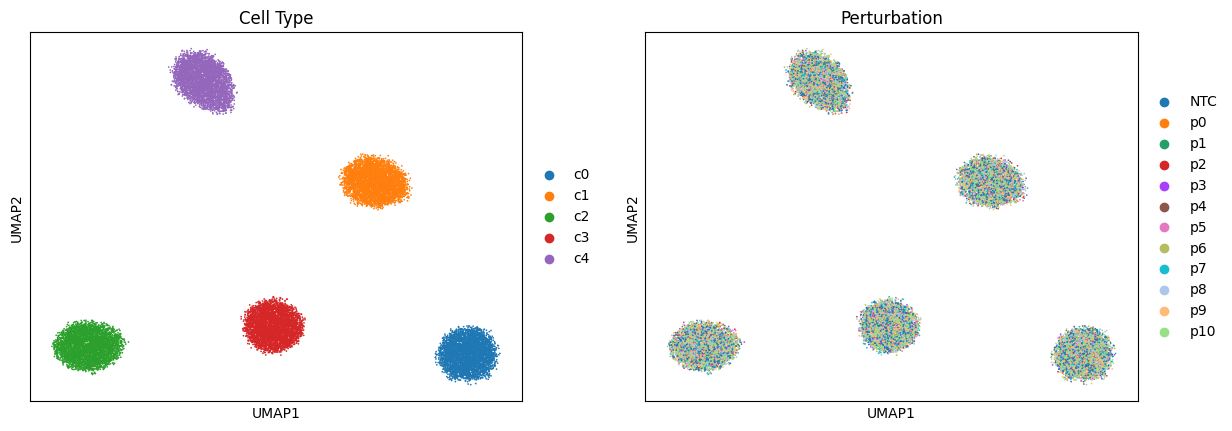

In [77]:
sc.pp.pca(adata, n_comps = 50)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color = ["cell_type", "perturbation"], title = ["Cell Type", "Perturbation"])

In [78]:
import scipy.sparse as sp
# If .X is dense or some other sparse type, convert to CSR
if not sp.isspmatrix_csr(adata.X):
    adata.X = sp.csr_matrix(adata.X)

In [49]:
type(adata.X)


scipy.sparse._csr.csr_matrix

In [79]:
print(adata.X[:5, :5].toarray())

[[ 7.951764  11.439913  10.259533   8.838936   9.074026 ]
 [ 9.699642  12.552691   8.748628   9.583623  10.438718 ]
 [ 7.728514  11.317629  10.140317   7.5226045 11.025462 ]
 [ 9.606927  12.543179  10.51557    9.496684  10.510451 ]
 [11.047664  11.427505   9.386991   7.2398376  9.458924 ]]


In [51]:
adata.write_h5ad("simulated_data_2.h5ad")
